In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
from nilmtk import DataSet

In [2]:
data = DataSet('./iawe.h5').buildings[1].elec

In [3]:
mains = next(data.mains().load())

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.


In [4]:
ac = next(data['air conditioner'].load())[('power','active')]
wm = next(data['washing machine'].load())[('power','active')]
fr = next(data['fridge'].load())[('power','active')]
cp = next(data['computer'].load())[('power','active')]
ir = next(data['clothes iron'].load())[('power','active')]
tv = next(data['television'].load())[('power','active')]
mo = next(data['motor'].load())[('power','active')]

In [5]:
appliances = [ac , wm , fr , cp , ir , tv , mo]

In [6]:
def preprocess(li_df):
    li = []
    for df in li_df:
        df = scipy.signal.medfilt(df, kernel_size=None)
        li.append(df)
    return li

In [7]:
appliances = preprocess(appliances)

In [8]:
ac = appliances[0]
wm = appliances[1]
fr = appliances[2]
cp = appliances[3]
ir = appliances[4]
tv = appliances[5]
mo = appliances[6]

In [9]:
mains = mains[('power','active')]

In [10]:
mains = scipy.signal.medfilt(mains, kernel_size=None)

In [11]:
def edge_detection(device):
    f,t,Zxx = scipy.signal.stft(device, fs=1.0, window='hamming', nperseg=10, 
                                noverlap=None, nfft=None, detrend=False, 
                                return_onesided=True, boundary='zeros', 
                                padded=True, axis=- 1)
    t = t.astype('int')
    
    return t

In [12]:
edges = edge_detection(ac)

In [13]:
len(edges)

128051

In [14]:
def grab_on_sig(edges,device,db):
    df = []
    for x in edges:
        if x in range(SIG_SIZE):
            pass
        elif x >= len(device)-SIG_SIZE:
            pass
        elif np.mean(device[x:x+SIG_SIZE])>np.mean(device[x-SIG_SIZE:x]+THRSHLD): #device consuming more than 20kWh
            df.append(device[x:x+SIG_SIZE])
            db.append(df)
            df=[]
    return db

In [15]:
db = [] #signature database
SIG_SIZE = 6
THRSHLD = 20
prev_len = 0
name_db = []

In [16]:
db = grab_on_sig(edges,ac,db)

In [17]:
l = len(db)
print(l)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('wm')

598


In [18]:
l

598

In [19]:
db = grab_on_sig(edges,wm,db)

In [20]:
l = len(db)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('wm')

In [21]:
l

775

In [22]:
db = grab_on_sig(edges,fr,db)

In [23]:
l = len(db)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('fr')

In [24]:
l

1628

In [25]:
db = grab_on_sig(edges,cp,db)

In [26]:
l = len(db)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('cp')

In [27]:
l

1678

In [28]:
db = grab_on_sig(edges,ir,db)

In [29]:
l = len(db)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('ir')

In [30]:
l

1826

In [31]:
db = grab_on_sig(edges,mo,db)

In [32]:
l = len(db)
mul = l-prev_len
prev_len = l
for x in range(mul):
    name_db.append('mo')

In [33]:
l

1955

In [34]:
len(db),len(name_db)

(1955, 1955)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [36]:
db = np.array(db)

In [37]:
db = db.reshape((l,SIG_SIZE))

In [38]:
db.shape

(1955, 6)

In [39]:
X = db

y = name_db

In [40]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [41]:
clf = RandomForestClassifier()

In [42]:
clf.fit(X_train,y_train)

RandomForestClassifier()

In [43]:
preds = clf.predict(X_test)==y_test

In [44]:
print(f'Total number of predictions = {preds.size}\n',
      f'Number of {np.unique(preds,return_counts=True)[0][0]} predictions = {np.unique(preds,return_counts=True)[1][0]}\n',
      f'Number of {np.unique(preds,return_counts=True)[0][1]} predictions= {np.unique(preds,return_counts=True)[1][1]}\n',
      f'Accuracy = {354/367*100:.2f}%')

Total number of predictions = 391
 Number of False predictions = 9
 Number of True predictions= 382
 Accuracy = 96.46%


In [84]:
def on_off_decision(edges,device):
    on_events = []
    off_events = []
    for x in edges:
        if x in range(SIG_SIZE) or x >= edges[-1]-SIG_SIZE :
            pass
        else:
            if np.mean(device[x:x+SIG_SIZE])>np.mean(device[x-SIG_SIZE:x]+THRSHLD): #device consuming more than 5kWh
                on_events.append(x)
            elif np.mean(device[x:x+SIG_SIZE])<np.mean(device[x-SIG_SIZE:x]-THRSHLD):
                off_events.append(x)
            else:
                pass
    return on_events

In [118]:
e= edge_detection(mains) # returns indexes 

In [119]:
e

array([   0,    5,   10,   15,   20,   25,   30,   35,   40,   45,   50,
         55,   60,   65,   70,   75,   80,   85,   90,   95,  100,  105,
        110,  115,  120,  125,  130,  135,  140,  145,  150,  155,  160,
        165,  170,  175,  180,  185,  190,  195,  200,  205,  210,  215,
        220,  225,  230,  235,  240,  245,  250,  255,  260,  265,  270,
        275,  280,  285,  290,  295,  300,  305,  310,  315,  320,  325,
        330,  335,  340,  345,  350,  355,  360,  365,  370,  375,  380,
        385,  390,  395,  400,  405,  410,  415,  420,  425,  430,  435,
        440,  445,  450,  455,  460,  465,  470,  475,  480,  485,  490,
        495,  500,  505,  510,  515,  520,  525,  530,  535,  540,  545,
        550,  555,  560,  565,  570,  575,  580,  585,  590,  595,  600,
        605,  610,  615,  620,  625,  630,  635,  640,  645,  650,  655,
        660,  665,  670,  675,  680,  685,  690,  695,  700,  705,  710,
        715,  720,  725,  730,  735,  740,  745,  7

In [120]:
e = on_off_decision(e,mains)

In [121]:
dbmains = []

In [122]:
dbmains = grab_on_sig(e,mains,dbmains)

In [123]:
l  = len(dbmains)

In [124]:
dbmains = np.array(dbmains).reshape((l,SIG_SIZE))

In [125]:
clf.predict(dbmains)

array(['wm', 'wm', 'wm', 'wm', 'ir', 'ir', 'wm', 'wm', 'wm', 'wm', 'wm',
       'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm', 'wm',
       'wm'], dtype='<U2')

In [126]:
main_preds = clf.predict(dbmains)

In [127]:
df = pd.DataFrame({'idx':e, 'preds':main_preds})

In [130]:
df,ev

(    idx preds
 0    10    wm
 1    25    wm
 2    40    wm
 3   105    wm
 4   110    ir
 5   115    ir
 6   175    wm
 7   180    wm
 8   185    wm
 9   200    wm
 10  220    wm
 11  225    wm
 12  310    wm
 13  330    wm
 14  335    wm
 15  370    wm
 16  375    wm
 17  385    wm
 18  405    wm
 19  410    wm
 20  705    wm
 21  710    wm
 22  715    wm,
 {'10': 'ac, tv',
  '100': 'wm',
  '150': 'fr',
  '300': 'computer',
  '310': 'iron',
  '700': 'motor'})

# **make dummy mains**

ac , wm , fr , cp , ir , tv , mo

In [115]:
for x in range(10):
    mains = np.insert(mains,0,0)

In [109]:
ac_test = ac[:1000]
wm_test = wm[:1000]
fr_test = fr[:1000]
cp_test = cp[:1000]
ir_test = ir[:1000]
tv_test = tv[:1000]
mo_test = mo[:1000]

In [110]:
ac_test[100:200] += wm_test[100:200]
ac_test[150:250] += fr_test[150:250]
ac_test[300:400] += cp_test[300:400]
ac_test[310:410] += ir_test[310:410]
ac_test[:200] += tv_test[:200]
ac_test[700:800] += mo_test[700:800]

In [129]:
ev = {'10':'ac, tv',
      '100': 'wm',
     '150':'fr',
     '300': 'computer',
     '310':'iron',
     '700':'motor'}

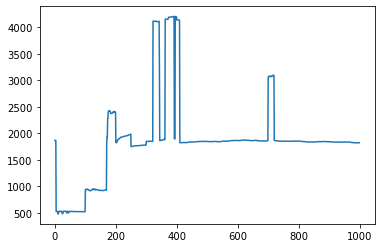

In [112]:
plt.plot(ac_test)

In [113]:
mains = ac_test

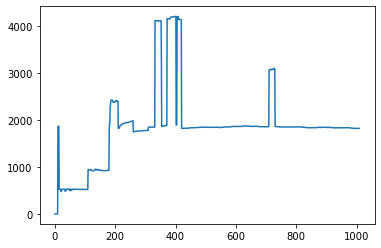

In [117]:
plt.plot(mains)